<a href="https://colab.research.google.com/github/ZKisielewska/learning-git-task/blob/master/M_18_3_NN_classification_fashion_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Module 18.3 Naural Network Classification: Fashion-MNIST**

As an example, we will use one of the iconic datasets - **Fashion MNIST**. This is a collection of images showing different outfits - sandals, t-shirts, pants, etc.. Fashion MNIST dataset contains 70,000 grayscale images in 10 categories.

1. The first step will be to implement a neural network on the previously used **Fashion-MNIST** set so as to obtain a result on the test data of **accuracy > 0.94** (or as close as possible), using the following division:

- **X_train, X_test, y_train, y_test = \
     train_test_split(images, labels, test_size=0.1, random_state=10, stratify=labels)**

2. The second step will be to **save and deliver the model** and write an interface that accepts the input value and returns the value predicted by our model along with the drawn input image (so that it can be visually verified if it works).

Saving models is described on the TensorFlow [website](https://www.tensorflow.org/tutorials/keras/save_and_load).

3. The third step will be to **raise our result to about 0.97** by using **augmentation** techniques, i.e. creating new data on the basis of existing data.

This will be relatively difficult as we have little training data, so you should do a little "research" in search of information on how to generate such data.

We especially recommend:

- [albumentation library](https://github.com/albumentations-team/albumentations)
- [Open resume library](https://docs.opencv.org/master/d6/d00/tutorial_py_root.html)

In [1]:
import warnings
from absl.logging import warning
import os

# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

print(tf.__version__)

2.12.0


## Import the Fashion MNIST dataset

In [2]:
# load the dataset
train, test = tf.keras.datasets.fashion_mnist.load_data()

# extraction of images and labels
images, labels = train

4422102/4422102 [==============================] - 0s 0us/step


The images are 28x28 NumPy arrays, with pixel values ranging from 0 to 255. The labels are an array of integers, ranging from 0 to 9. These correspond to the class of clothing the image represents:

```
Label	Class
0	 T-shirt/top
1	 Trouser
2	 Pullover
3	 Dress
4	 Coat
5	 Sandal
6	 Shirt
7	 Sneaker
8	 Bag
9	 Ankle boot
```
Each image is mapped to a single label. Since the class names are not included with the dataset, store them here to use later when plotting the images:

In [3]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

## Preprocess the data

The data must be preprocessed before training the network. Let's start by normalizing it. Next, we need to convert our data into a format that Tensorflow understands, Dataset. We will create a dataset and using the available methods we will set the **batch_size** to 32, and we will **shuffle** our dataset.

In [4]:
# pixel value normalization (max. value
# is 255.0, which is to normalize our data,
# we need to divide each pixel by the max value)
images = images/255.0

# save data as int
labels = labels.astype(np.int32)

In [5]:
from sklearn.model_selection import train_test_split

# split the data
X_train, X_test, y_train, y_test = \
    train_test_split(images, labels, test_size=0.1, random_state=10, stratify=labels)

# create a Dataset from the list
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))

# setting batch_size to 32 and reshuffling based on 1000 samples
train_ds = train_ds.shuffle(1000).batch(32)

Let's display the first 16 images and display the class name below each image.

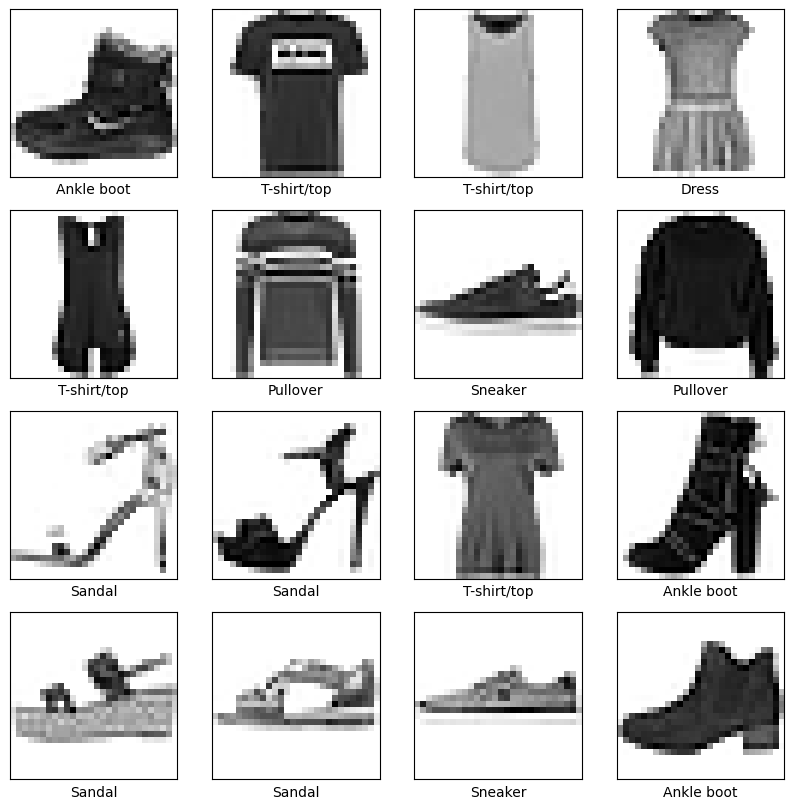

In [6]:
plt.figure(figsize=(10, 10))
for i in range(16):
  plt.subplot(4,4, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(images[i], cmap=plt.cm.binary)
  plt.xlabel(class_names[labels[i]])
plt.show()

## Build the model
Building the neural network model requires configuring the **layers** of the model, then **compiling** the model.

### Set up the layers

The basic building block of a neural network is the [*layer*](https://www.tensorflow.org/api_docs/python/tf/keras/layers). Layers extract representations from the data fed into them.

- At the input, we need to **flatten** the data. This transforms the format of the images from a two-dimensional array (of 28 by 28 pixels) to a one-dimensional array (of 28 * 28 = 784 pixels). This layer has no parameters to learn; it only reformats the data.

- After the pixels are flattened, the network consists of a sequence of ```tf.keras.layers.Dense```tf.keras.layers. **Dense layers**. These are densely connected, or fully connected, neural layers.

- Select the appropriate **activation function** for subsequent layers.

- The number of **hidden layer** neurons should decrease closer to the output of our model (usually this approach works best, e.g. 300, 200, 100, 5).

- The **output** should have as many neurons as there are **classes in our set**.

### Compile the model

Before the model is ready for training, it needs a few more settings. These are added during the model's [*compile*](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile) step:

* [*Loss function*](https://www.tensorflow.org/api_docs/python/tf/keras/losses) — This measures how accurate the model is during training. You want to minimize this function to "steer" the model in the right direction.

* [*Optimizer*](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers) — This is how the model is updated based on the data it sees and its loss function.

* [*Metrics*](https://www.tensorflow.org/api_docs/python/tf/keras/metrics) — Used to monitor the training and testing steps. The following example uses *accuracy*, the fraction of the images that are correctly classified.

At this point, it is worth noting that all operations available on models are described in the [Model](https://www.tensorflow.org/api_docs/python/tf/keras/Model|) class, because no matter what method we use to create our network, each of them inherits from the **Model** class.

We will try to compile our model using:

- '**adam**' optimizer,
- '**sparse_categorical_crossentropy**' loss function,
- '**accuracy**' metric.

In [7]:
# function creating the model
def create_model():
  model = tf.keras.Sequential([
      tf.keras.layers.Flatten(input_shape=(28, 28)), # flattening an image to a one-dimensional vector
      tf.keras.layers.Dense(300, activation='relu', name='input_layer'),
      tf.keras.layers.Dense(200, activation='relu', name='hidden_layer_1'),
      tf.keras.layers.Dense(100, activation='relu', name='hidden_layer_2'),
      tf.keras.layers.Dense(10, activation='softmax', name='output_layer') # the last layer has as many neurons as there are classes
  ])

  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

  return model

# create a basic model instance
model = create_model()

# display the model's architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 input_layer (Dense)         (None, 300)               235500    
                                                                 
 hidden_layer_1 (Dense)      (None, 200)               60200     
                                                                 
 hidden_layer_2 (Dense)      (None, 100)               20100     
                                                                 
 output_layer (Dense)        (None, 10)                1010      
                                                                 
Total params: 316,810
Trainable params: 316,810
Non-trainable params: 0
_________________________________________________________________


### Train the model Save checkpoints during training

Model training is done using the [fit](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) method of the Model class.

It accepts many different parameters, but we are only interested in a few of them:

- **x** – input data, in our case images of clothes,
- **y** – labels for our dataset.

**Attention:** Having prepared the dataset as we did before, instead of explicitly specifying **x**, **y**, we pass the entire dataset at once. We do this because it will return a pair (**data, label)** every iteration.

- **epochs** - for how many epochs should we train our model,
- **validation_data** – set if we want to provide data for validating our model after each epoch. This parameter is often used if we have validation data.

**Attention:** Instead of **validation_data**, you can use the **validation_split** parameter, which tells us what percentage of training data should be used for validation every epoch.

With this information, let's train our model on the previously created set using:

- 10 epochs
- verbose=1
- validation on 10% of the training set

In [12]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 save_best_only=True,
                                                 monitor='val_accuracy')

# train the model with the new callback
stats = model.fit(train_ds, epochs=30, verbose=1, callbacks=[cp_callback])

Epoch 1/30
1686/1688 [============================>.] - ETA: 0s - loss: 0.1605 - accuracy: 0.9379

1688/1688 [==============================] - 11s 6ms/step - loss: 0.1605 - accuracy: 0.9379
Epoch 2/30
1684/1688 [============================>.] - ETA: 0s - loss: 0.1547 - accuracy: 0.9401

1688/1688 [==============================] - 10s 6ms/step - loss: 0.1548 - accuracy: 0.9401
Epoch 3/30
1684/1688 [============================>.] - ETA: 0s - loss: 0.1472 - accuracy: 0.9424

1688/1688 [==============================] - 9s 5ms/step - loss: 0.1472 - accuracy: 0.9424
Epoch 4/30
1680/1688 [============================>.] - ETA: 0s - loss: 0.1467 - accuracy: 0.9440

1688/1688 [==============================] - 10s 6ms/step - loss: 0.1466 - accuracy: 0.9441
Epoch 5/30
1686/1688 [============================>.] - ETA: 0s - loss: 0.1463 - accuracy: 0.9447

1688/1688 [==============================] - 10s 6ms/step - loss: 0.1464 - accuracy: 0.9447
Epoch 6/30
1682/1688 [============================>.] - ETA: 0s - loss: 0.1361 - accuracy: 0.9476

1688/1688 [==============================] - 10s 6ms/step - loss: 0.1359 - accuracy: 0.9476
Epoch 7/30
1684/1688 [============================>.] - ETA: 0s - loss: 0.1396 - accuracy: 0.9468

1688/1688 [==============================] - 9s 6ms/step - loss: 0.1395 - accuracy: 0.9469
Epoch 8/30
1686/1688 [============================>.] - ETA: 0s - loss: 0.1283 - accuracy: 0.9500

1688/1688 [==============================] - 9s 5ms/step - loss: 0.1285 - accuracy: 0.9499
Epoch 9/30
1681/1688 [============================>.] - ETA: 0s - loss: 0.1354 - accuracy: 0.9486

1688/1688 [==============================] - 10s 6ms/step - loss: 0.1354 - accuracy: 0.9486
Epoch 10/30
1687/1688 [============================>.] - ETA: 0s - loss: 0.1266 - accuracy: 0.9513

1688/1688 [==============================] - 10s 6ms/step - loss: 0.1266 - accuracy: 0.9513
Epoch 11/30
1687/1688 [============================>.] - ETA: 0s - loss: 0.1253 - accuracy: 0.9517

1688/1688 [==============================] - 10s 6ms/step - loss: 0.1253 - accuracy: 0.9517
Epoch 12/30
1687/1688 [============================>.] - ETA: 0s - loss: 0.1209 - accuracy: 0.9535

1688/1688 [==============================] - 10s 6ms/step - loss: 0.1209 - accuracy: 0.9535
Epoch 13/30
1686/1688 [============================>.] - ETA: 0s - loss: 0.1198 - accuracy: 0.9543

1688/1688 [==============================] - 10s 6ms/step - loss: 0.1198 - accuracy: 0.9543
Epoch 14/30
1686/1688 [============================>.] - ETA: 0s - loss: 0.1168 - accuracy: 0.9546

1688/1688 [==============================] - 10s 6ms/step - loss: 0.1168 - accuracy: 0.9546
Epoch 15/30
1687/1688 [============================>.] - ETA: 0s - loss: 0.1184 - accuracy: 0.9554

1688/1688 [==============================] - 10s 6ms/step - loss: 0.1184 - accuracy: 0.9554
Epoch 16/30
1682/1688 [============================>.] - ETA: 0s - loss: 0.1119 - accuracy: 0.9566

1688/1688 [==============================] - 10s 6ms/step - loss: 0.1117 - accuracy: 0.9567
Epoch 17/30
1686/1688 [============================>.] - ETA: 0s - loss: 0.1096 - accuracy: 0.9578

1688/1688 [==============================] - 10s 6ms/step - loss: 0.1097 - accuracy: 0.9578
Epoch 18/30
1681/1688 [============================>.] - ETA: 0s - loss: 0.1066 - accuracy: 0.9588

1688/1688 [==============================] - 10s 6ms/step - loss: 0.1064 - accuracy: 0.9589
Epoch 19/30
1679/1688 [============================>.] - ETA: 0s - loss: 0.1084 - accuracy: 0.9585

1688/1688 [==============================] - 9s 5ms/step - loss: 0.1083 - accuracy: 0.9586
Epoch 20/30
1684/1688 [============================>.] - ETA: 0s - loss: 0.1041 - accuracy: 0.9602

1688/1688 [==============================] - 10s 6ms/step - loss: 0.1047 - accuracy: 0.9602
Epoch 21/30
1683/1688 [============================>.] - ETA: 0s - loss: 0.0989 - accuracy: 0.9621

1688/1688 [==============================] - 10s 6ms/step - loss: 0.0988 - accuracy: 0.9621
Epoch 22/30
1679/1688 [============================>.] - ETA: 0s - loss: 0.0989 - accuracy: 0.9619

1688/1688 [==============================] - 10s 6ms/step - loss: 0.0991 - accuracy: 0.9619
Epoch 23/30
1687/1688 [============================>.] - ETA: 0s - loss: 0.0972 - accuracy: 0.9633

1688/1688 [==============================] - 9s 6ms/step - loss: 0.0972 - accuracy: 0.9633
Epoch 24/30
1682/1688 [============================>.] - ETA: 0s - loss: 0.0971 - accuracy: 0.9627

1688/1688 [==============================] - 10s 6ms/step - loss: 0.0970 - accuracy: 0.9628
Epoch 25/30
1687/1688 [============================>.] - ETA: 0s - loss: 0.0966 - accuracy: 0.9639

1688/1688 [==============================] - 10s 6ms/step - loss: 0.0966 - accuracy: 0.9639
Epoch 26/30
1683/1688 [============================>.] - ETA: 0s - loss: 0.0979 - accuracy: 0.9634

1688/1688 [==============================] - 10s 6ms/step - loss: 0.0980 - accuracy: 0.9634
Epoch 27/30
1684/1688 [============================>.] - ETA: 0s - loss: 0.0919 - accuracy: 0.9655

1688/1688 [==============================] - 9s 5ms/step - loss: 0.0918 - accuracy: 0.9655
Epoch 28/30
1680/1688 [============================>.] - ETA: 0s - loss: 0.0897 - accuracy: 0.9667

1688/1688 [==============================] - 9s 6ms/step - loss: 0.0896 - accuracy: 0.9667
Epoch 29/30
1680/1688 [============================>.] - ETA: 0s - loss: 0.0959 - accuracy: 0.9644

1688/1688 [==============================] - 10s 6ms/step - loss: 0.0958 - accuracy: 0.9644
Epoch 30/30
1684/1688 [============================>.] - ETA: 0s - loss: 0.0913 - accuracy: 0.9659

1688/1688 [==============================] - 10s 6ms/step - loss: 0.0913 - accuracy: 0.9659


This model reaches an accuracy of about 0.96 (or 96,59%) on the training data.

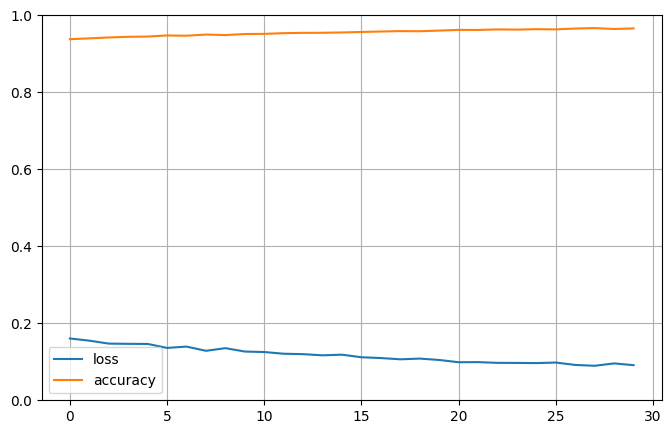

In [13]:
pd.DataFrame(stats.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

As you can see, the metric **(accuracy) increases** with successive epochs, while the error **(loss) decreases**.

The training and inference environments are usually separate. Models need to be **saved** after they are validated. They are then loaded into the inference environments for actual prediction.

In [11]:
import keras
# save the model
model.save('fashion_mnist')

# load the model
loaded_model = tf.keras.models.load_model('fashion_mnist')

# print the model summary
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 input_layer (Dense)         (None, 300)               235500    
                                                                 
 hidden_layer_1 (Dense)      (None, 200)               60200     
                                                                 
 hidden_layer_2 (Dense)      (None, 100)               20100     
                                                                 
 output_layer (Dense)        (None, 10)                1010      
                                                                 
Total params: 316,810
Trainable params: 316,810
Non-trainable params: 0
_________________________________________________________________


### Model evaluation

Next, compare how the model performs on the test dataset:

In [25]:
def evaluate_model(model, X_test, y_test, stats):

    # numerical prediction
    y_pred = model.predict(X_test)
    print("probs : ", y_pred[2])
    print("class :", np.argmax(y_pred[2]))
    print("actual class : ", y_test[2])

    # model results visualization
    pd.DataFrame(stats.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

    # f1_score
    y_pred = np.argmax(y_pred,axis=1)
    scores = f1_score(y_test, y_pred, average='macro')
    print(f'F1 Score : {scores}')

    # confusion matrix
    conf_mx = confusion_matrix(y_test, y_pred)
    row_sums = conf_mx.sum(axis=1, keepdims=True)
    norm_conf_mx = conf_mx / row_sums
    np.fill_diagonal(norm_conf_mx, 0)
    plt.matshow(conf_mx, cmap='Dark2')
    plt.title('Confusion Matrix')
    plt.show()

    # treu label
    plt.imshow(np.array(X_test[2]))
    plt.title('True image')
    plt.title(y_test[2])

188/188 [==============================] - 1s 6ms/step
probs :  [1.1328838e-24 1.8719559e-22 9.8162252e-26 1.3701905e-21 2.7140004e-24
 8.8423544e-09 3.9206308e-23 9.9999994e-01 6.1215749e-18 1.3148245e-10]
klasa : 7
rzeczywista klasa:  7


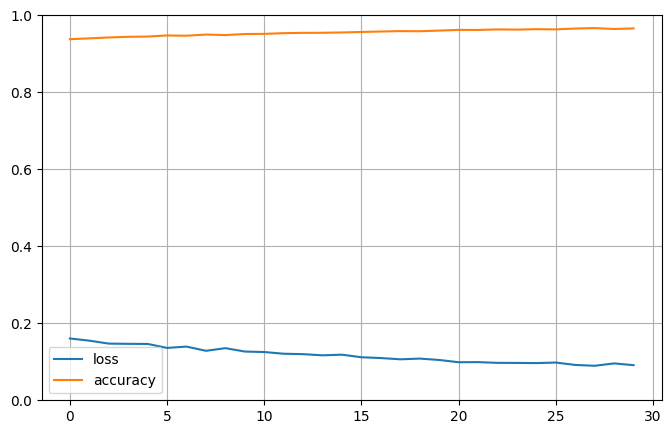

F1 Score modelu to 0.8898407768452359


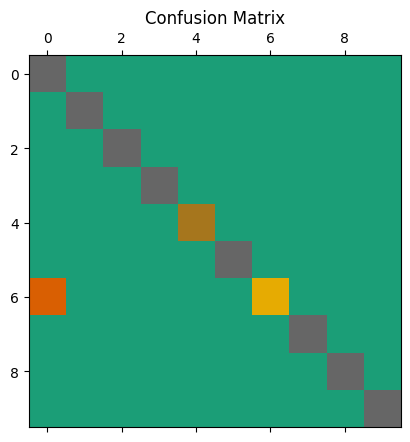

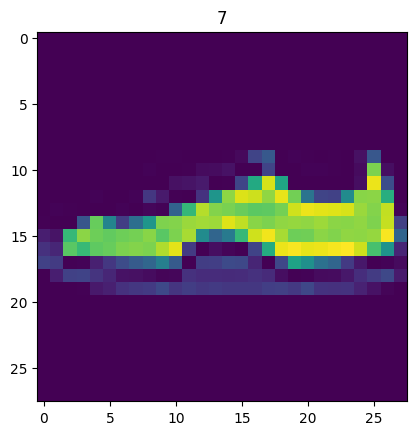

In [27]:
evaluate_model(model, X_test, y_test, stats)

The model correctly classified the image.

## Albumentations

Albumentations is a Python library for image augmentation. Image augmentation is used in deep learning and computer vision tasks to increase the quality of trained models. The purpose of image augmentation is to create new training samples from the existing data.

In [48]:
import albumentations as A

In [49]:
def albumentation(data):

    fliped_images = []

    for image in data:

        # Declare an augmentation pipeline
        transform = A.Compose([
        A.HorizontalFlip(p=1),
        A.GaussNoise(var_limit=(0.0001, 0.017), always_apply=True)
        ])

        transformed = transform(image=image)
        new_image = transformed['image']
        fliped_images.append(new_image)



    images_2 = np.array(fliped_images)

    return images_2

In [63]:
train_2, test_2 = tf.keras.datasets.fashion_mnist.load_data()
images_2, labels_2 = train_2

images_2 = images_2/255.0

labels_2 = labels_2.astype(np.int32)

In [64]:
# create new images with albumentation function
new_images = albumentation(images_2)

In [65]:
np.shape(new_images)

(60000, 28, 28)

In [66]:
# split new data
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(new_images, labels_2, test_size=0.1, random_state=10, stratify=labels_2)

In [67]:
train_ds_2 = tf.data.Dataset.from_tensor_slices((X_train_2, y_train_2))

In [68]:
train_ds_2 = train_ds_2.shuffle(1000).batch(32)

In [69]:
# train the model
stats = model.fit(train_ds_2, epochs=20, verbose=1, callbacks=[cp_callback])

Epoch 1/20
1688/1688 [==============================] - ETA: 0s - loss: 0.2129 - accuracy: 0.9236

1688/1688 [==============================] - 11s 6ms/step - loss: 0.2129 - accuracy: 0.9236
Epoch 2/20
1688/1688 [==============================] - ETA: 0s - loss: 0.1684 - accuracy: 0.9353

1688/1688 [==============================] - 11s 6ms/step - loss: 0.1684 - accuracy: 0.9353
Epoch 3/20
1682/1688 [============================>.] - ETA: 0s - loss: 0.1571 - accuracy: 0.9384

1688/1688 [==============================] - 10s 6ms/step - loss: 0.1570 - accuracy: 0.9385
Epoch 4/20
1679/1688 [============================>.] - ETA: 0s - loss: 0.1421 - accuracy: 0.9455

1688/1688 [==============================] - 10s 6ms/step - loss: 0.1423 - accuracy: 0.9455
Epoch 5/20
1683/1688 [============================>.] - ETA: 0s - loss: 0.1355 - accuracy: 0.9465

1688/1688 [==============================] - 10s 6ms/step - loss: 0.1354 - accuracy: 0.9466
Epoch 6/20
1688/1688 [==============================] - ETA: 0s - loss: 0.1290 - accuracy: 0.9503

1688/1688 [==============================] - 11s 7ms/step - loss: 0.1290 - accuracy: 0.9503
Epoch 7/20
1687/1688 [============================>.] - ETA: 0s - loss: 0.1253 - accuracy: 0.9524

1688/1688 [==============================] - 10s 6ms/step - loss: 0.1252 - accuracy: 0.9525
Epoch 8/20
1680/1688 [============================>.] - ETA: 0s - loss: 0.1205 - accuracy: 0.9546

1688/1688 [==============================] - 10s 6ms/step - loss: 0.1204 - accuracy: 0.9546
Epoch 9/20
1687/1688 [============================>.] - ETA: 0s - loss: 0.1106 - accuracy: 0.9571

1688/1688 [==============================] - 10s 6ms/step - loss: 0.1106 - accuracy: 0.9571
Epoch 10/20
1681/1688 [============================>.] - ETA: 0s - loss: 0.1120 - accuracy: 0.9577

1688/1688 [==============================] - 10s 6ms/step - loss: 0.1119 - accuracy: 0.9577
Epoch 11/20
1687/1688 [============================>.] - ETA: 0s - loss: 0.1100 - accuracy: 0.9593

1688/1688 [==============================] - 11s 6ms/step - loss: 0.1100 - accuracy: 0.9593
Epoch 12/20
1685/1688 [============================>.] - ETA: 0s - loss: 0.1092 - accuracy: 0.9594

1688/1688 [==============================] - 10s 6ms/step - loss: 0.1093 - accuracy: 0.9594
Epoch 13/20
1688/1688 [==============================] - ETA: 0s - loss: 0.0962 - accuracy: 0.9626

1688/1688 [==============================] - 11s 6ms/step - loss: 0.0962 - accuracy: 0.9626
Epoch 14/20
1688/1688 [==============================] - ETA: 0s - loss: 0.0975 - accuracy: 0.9630

1688/1688 [==============================] - 11s 6ms/step - loss: 0.0975 - accuracy: 0.9630
Epoch 15/20
1688/1688 [==============================] - ETA: 0s - loss: 0.0973 - accuracy: 0.9629

1688/1688 [==============================] - 11s 6ms/step - loss: 0.0973 - accuracy: 0.9629
Epoch 16/20
1681/1688 [============================>.] - ETA: 0s - loss: 0.0888 - accuracy: 0.9667

1688/1688 [==============================] - 11s 7ms/step - loss: 0.0887 - accuracy: 0.9667
Epoch 17/20
1684/1688 [============================>.] - ETA: 0s - loss: 0.0891 - accuracy: 0.9662

1688/1688 [==============================] - 11s 6ms/step - loss: 0.0892 - accuracy: 0.9661
Epoch 18/20
1681/1688 [============================>.] - ETA: 0s - loss: 0.0875 - accuracy: 0.9673

1688/1688 [==============================] - 11s 6ms/step - loss: 0.0875 - accuracy: 0.9673
Epoch 19/20
1684/1688 [============================>.] - ETA: 0s - loss: 0.0858 - accuracy: 0.9688

1688/1688 [==============================] - 11s 6ms/step - loss: 0.0857 - accuracy: 0.9687
Epoch 20/20
1680/1688 [============================>.] - ETA: 0s - loss: 0.0807 - accuracy: 0.9706

1688/1688 [==============================] - 11s 6ms/step - loss: 0.0807 - accuracy: 0.9707


This model reaches an accuracy of about 0.97 (or 97,07%) on the training data.